# Unet

This page describes the implementation of the unet network architecture in Torch.

In [1]:
from tqdm import tqdm
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms as T

test_picture = 500

## Data set

Will be used `OxfordIIITPet`. We will load it with `target_types = 'segmentation'` so for each picutre we will have picture itself and mask for it.

### Pictures

Here is an example of what we deal with as images.

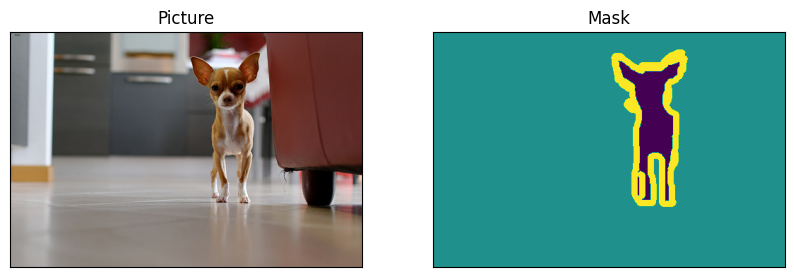

In [2]:
train_dataset = OxfordIIITPet(
    "OxfordIIITPet/", 
    target_types = "segmentation", 
    download = True
)
test_dataset = OxfordIIITPet(
    "OxfordIIITPet/", 
    target_types = "segmentation", 
    download = True,
    split = "test"
)

plt.figure(figsize = (10, 9))
plt.subplot(121)
plt.imshow(train_dataset[test_picture][0])
plt.xticks([]);plt.yticks([])
plt.title("Picture")

plt.subplot(122)
plt.imshow(train_dataset[test_picture][1])
plt.xticks([]);plt.yticks([])
plt.title("Mask")

plt.show()

### Transfomations

The network does not understand images. So we have to create tensors from images. Here we have added some transformations to our dataset. Let's see what they do.

In [3]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])
target_transfrom = T.Compose([
    T.Resize((256, 256)),
    T.PILToTensor(),
    # classes are marked starting with 1
    # but in python it's easier to work with
    # with sets that start with 0, so the following
    # transformation fixes this inconvenience
    T.Lambda(lambda x: (x - 1).long())
])

transforms = (
    torchvision.datasets.
    vision.StandardTransform(transform, target_transfrom)
)

train_dataset.transforms = transforms
test_dataset.transforms = transforms

This is the shape of the tensor used as input to the model - it's regular three channel picture.

In [4]:
train_dataset[test_picture][0].shape

torch.Size([3, 256, 256])

This is the shape and unique values that appear in the target. So it's just an array whose shape is the same as the shape of the input images, but it only takes three values.

In [5]:
print("Shape:", list(train_dataset[test_picture][1].shape))
print("Values:", list(train_dataset[test_picture][1].unique()))

Shape: [1, 256, 256]
Values: [tensor(0), tensor(1), tensor(2)]


## Architecture

Here is a description of the transformation sequence that we usually understand as the UNET architecture.

To show sequence of trainsformations we will take one picture from dataset. But all transformations are usually performed on a batch of objects, so we need `unsqueeze(0)' to simulate a batch of one object.

In [6]:
example_image = test_dataset[0][0].unsqueeze(0)
example_image.shape

torch.Size([1, 3, 256, 256])

`base_channels` is hyper parameter of the UNET. Usually more `base_channels` leads to a more complex model.

In [7]:
base_channels = 16

### Operations

The following cell defines a function that returns a transformation that allows to change the number of channels of input data. It's a very common operation for the UNET architecture.

In [8]:
def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

We also need a transformation that reduces the resolution of the data for the down blocks.

In [9]:
downsample = nn.MaxPool2d(kernel_size=2, stride=2)

### Down blocks

Each down block should first increase the number of channels and make the image smaller - downscale the image. But we need to save the state of the data after increasing the channels to use it later in up blocks.

In [10]:
print("Input shape:", example_image.shape)
down1 = conv_plus_conv(in_channels = 3, out_channels = base_channels)
residual1 = down1(example_image)
print("Increased channels shape:", residual1.shape)
down_result = downsample(residual1)
print("Downsampled resolution shape:", down_result.shape)

Input shape: torch.Size([1, 3, 256, 256])
Increased channels shape: torch.Size([1, 16, 256, 256])
Downsampled resolution shape: torch.Size([1, 16, 128, 128])


We repeat this operation several times. For example, let's do it one more time. Usually more repetitions lead to better results.

In [11]:
print("Input shape:", down_result.shape)
down2 = conv_plus_conv(in_channels = base_channels, out_channels = base_channels*2)
residual2 = down2(down_result)
print("Increased channels shape:", residual2.shape)
down_result = downsample(residual2)
print("Downsampled resolution shape:", down_result.shape)

Input shape: torch.Size([1, 16, 128, 128])
Increased channels shape: torch.Size([1, 32, 128, 128])
Downsampled resolution shape: torch.Size([1, 32, 64, 64])


### Bottle neck

Is just convolutional transfomation that saves all dimentions of the data.

In [12]:
print("Input shape:", down_result.shape)
bottleneck = conv_plus_conv(base_channels * 2, base_channels * 2)
bottleneck_result = bottleneck(down_result)
print("Output shape:", bottleneck_result.shape)

Input shape: torch.Size([1, 32, 64, 64])
Output shape: torch.Size([1, 32, 64, 64])


### Up blocks

The up blocks carry out essentially the reverse operations:

- Increse resolution of the picture;
- Decrease number of channels.

But it also concatenates channels from down blocks - that is why we stored this information in down blocks.

In [13]:
print("Input shape:", bottleneck_result.shape)
up_result = nn.functional.interpolate(bottleneck_result, scale_factor=2)
print("Upsampled shape:", up_result.shape)
up_result = torch.cat((up_result, residual2), dim=1)
print("Concatenated shape:", up_result.shape)
up2 = conv_plus_conv(base_channels * 4, base_channels)
up_result = up2(up_result)
print("Channels decreased shape:", up_result.shape)

Input shape: torch.Size([1, 32, 64, 64])
Upsampled shape: torch.Size([1, 32, 128, 128])
Concatenated shape: torch.Size([1, 64, 128, 128])
Channels decreased shape: torch.Size([1, 16, 128, 128])


This operation is repeated as many times as there have been blocks down. So for this example we need to repeate it one more time:

In [14]:
print("Input shape:", up_result.shape)
up_result = nn.functional.interpolate(up_result, scale_factor=2)
print("Upsampled shape:", up_result.shape)
up_result = torch.cat((up_result, residual1), dim=1)
print("Concatenated shape:", up_result.shape)
up1 = conv_plus_conv(base_channels * 2, base_channels)
up_result = up1(up_result)
print("Channels decreased shape:", up_result.shape)

Input shape: torch.Size([1, 16, 128, 128])
Upsampled shape: torch.Size([1, 16, 256, 256])
Concatenated shape: torch.Size([1, 32, 256, 256])
Channels decreased shape: torch.Size([1, 16, 256, 256])


### Out

And the final prediction is produced by the base convolutional layer, which returns the original number of classes.

In [15]:
out = nn.Conv2d(
    in_channels=base_channels, 
    out_channels=3, 
    kernel_size=1
)
result = out(up_result)
result.shape

torch.Size([1, 3, 256, 256])

## Model fitting

Now let's try to build model based on described architecture.

### Defining model

Following class implements UNET in torch.

In [16]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels*2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels*4, base_channels * 8)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels*2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels*4)

        self.bottleneck = conv_plus_conv(base_channels * 8, base_channels * 8)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        residual1 = self.down1(x)
        x = self.downsample(residual1)
        residual2 = self.down2(x)
        x = self.downsample(residual2)
        residual3 = self.down3(x)
        x = self.downsample(residual3)
        residual4 = self.down4(x)
        x = self.downsample(residual4)

        x = self.bottleneck(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual4), dim=1)
        x = self.up4(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)
        x = self.up1(x)

        x = self.out(x)

        return x

Let's check that everything goes fine, transformations are performed without errors and the output dimension is as expected.

In [17]:
model = UNET()
model(test_dataset[0][0].unsqueeze(0)).shape

torch.Size([1, 3, 256, 256])

### Train funtions

This is where we define the functions we're going to use for the train model and evaluate its accuracy.

In [18]:
def train(
    model, device, optimizer, loss_fn, loader
) -> float:
    '''
    Traning algorithm.
    '''
    
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Train'):
        bs = y.size(0)
        x, y = x.to(device), y.squeeze(1).to(device)
        optimizer.zero_grad()

        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(loader)
    accuracy = correct / total

    return train_loss, accuracy

@torch.inference_mode()
def evaluate(model, loader, device, loss_fn) -> tuple[float, float]:
    '''
    Evaluation function.
    '''
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

### Toy example

Here is an example of a toy with a small data subset and small batches. So it can be fitted with weak devices. It just to make sure that everything goes fine.

Let's check `train` function.

``` python
np.random.seed(150)
idx = np.random.randint(len(train_dataset), size=200)
toy_loader = DataLoader([train_dataset[i] for i in idx], batch_size = 10)
toy_model = UNET()

for epoch in range(10):
    train(
        model = toy_model,
        device = torch.device('cpu'),
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3),
        loss_fn = nn.CrossEntropyLoss(),
        loader = toy_loader
    )
torch.save(toy_model.state_dict(), 'unet_files/toy_model.pt')
```

And `evaluate` function as well.

``` python
idx = np.random.randint(len(test_dataset), size=100)
evaluate(
    model = toy_model,
    loader = DataLoader([test_dataset[i] for i in idx], batch_size = 10),
    device = torch.device('cpu'),
    loss_fn = nn.CrossEntropyLoss()
)
```

Despite the fact that we have simplified the learning process as much as possible, it still takes quite a long time. For this reason and for the reproducibility of the experiment, we have saved the state of the model and will unload it in the next cell.

In [19]:
toy_model = UNET()
toy_model.load_state_dict(torch.load('unet_files/toy_model.pt'))

<All keys matched successfully>

Now let's see if we can get something interesting. Let's look at one of the images we used for training - does it look like something is working? All the results weren't even close, but I picked one where the object's features are clearly visible in the prediction. It might be worth trying to fit the model more seriously.

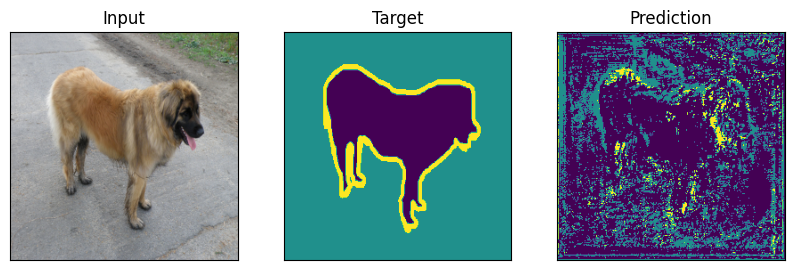

In [20]:
plt.figure(figsize = (10, 9))

picture_ind = 2812

plt.subplot(131)
plt.title("Input")
plt.imshow(T.ToPILImage()(train_dataset[picture_ind][0]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.title("Target")
plt.imshow(T.ToPILImage()(train_dataset[picture_ind][1].to(torch.uint8)))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.title("Prediction")
prediction = toy_model(train_dataset[picture_ind][0].unsqueeze(0))[0].max(dim=0)[1].to(torch.uint8)
plt.imshow(prediction)
plt.xticks([]); plt.yticks([])

plt.show()

### Final model

Here is the final, serious fitting of the model. If available, the GPU will be used, so we'll be able to make the batch bigger and evaluate the model on the train just during the training run.

Third-party services providing computing power were used to fit this model. But the code used for fitting is presented below.

``` python
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
if torch.cuda.is_available():
    print("Using device_name: ", torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()
model = UNET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)
```

``` python
fit_monitoring = {
    "train_losses" : [],
    "train_accuracies" : [],
    "test_losses" : [],
    "test_accuracies" : []
}

for epoch in range(25):
    train_loss, train_accuracy = train(
        model = model,
        device = device,
        optimizer = optimizer,
        loss_fn = loss_fn,
        loader = train_loader
    )
    test_loss, test_accuracy = evaluate(
        model = model,
        loader = test_loader,
        device = device,
        loss_fn = loss_fn
    )

    fit_monitoring["train_losses"].append(train_loss)
    fit_monitoring["train_accuracies"].append(train_accuracy)
    fit_monitoring["test_losses"].append(test_loss)
    fit_monitoring["test_accuracies"].append(test_accuracy)


torch.save(model.state_dict(), 'model.pt')
pickle.dump(fit_monitoring, open("fit_monitoring.pck", "wb"))
```

The model quality scores by epoch are shown in the cell below:

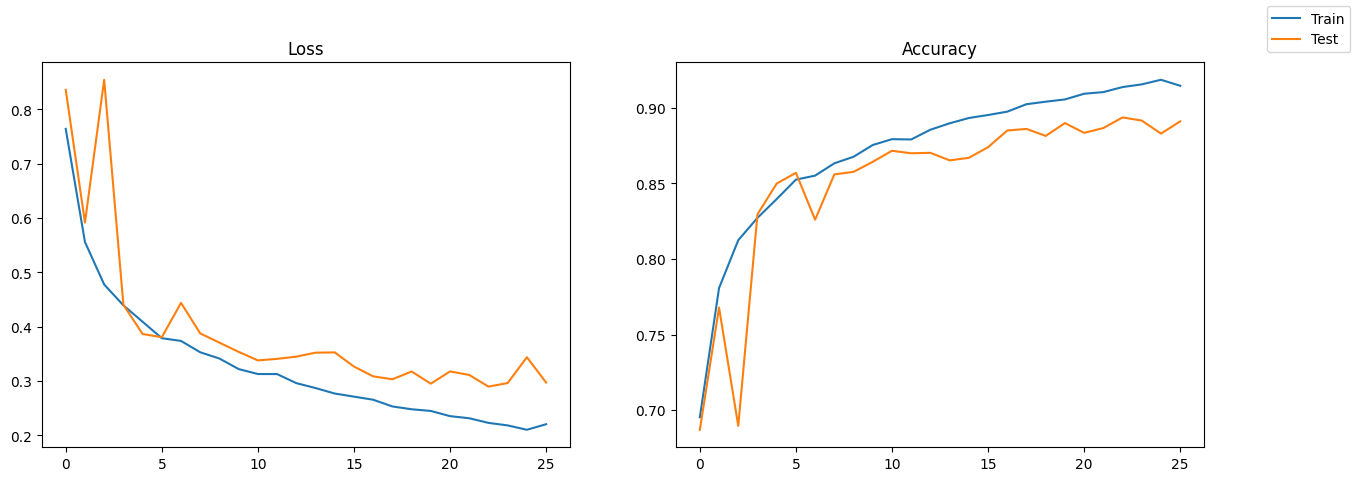

In [21]:
fit_monitoring = pickle.load(open("unet_files/fit_monitoring.pck", "rb"))

fig = plt.figure(figsize = (15, 5))

plt.subplot(121)
plt.title("Loss")
plt.plot(fit_monitoring["train_losses"])
plt.plot(fit_monitoring["test_losses"])

plt.subplot(122)
plt.title("Accuracy")
plt.plot(fit_monitoring["train_accuracies"])
plt.plot(fit_monitoring["test_accuracies"])

fig.legend(["Train", "Test"])

plt.show()

Finally, we want to show how the received model deals with a specific image from the test dataset.

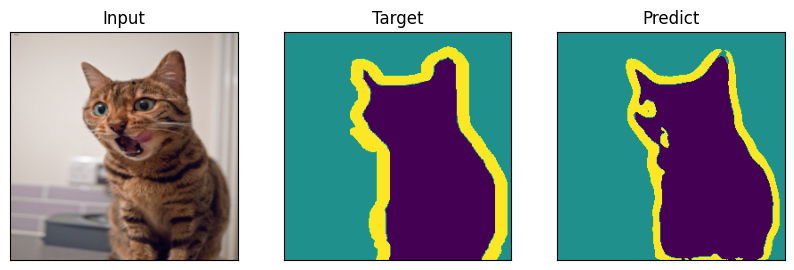

In [22]:
model = UNET()
model.load_state_dict(
    torch.load(
        'unet_files/model.pt', 
        map_location=torch.device('cpu')
    )
)

plt.figure(figsize = (10, 9))

plt.subplot(131)
plt.title("Input")
plt.imshow(T.ToPILImage()(test_dataset[543][0]))
plt.xticks([]);plt.yticks([])

plt.subplot(132)
plt.title("Target")
plt.imshow(T.ToPILImage()(test_dataset[543][1].to(torch.uint8)))
plt.xticks([]);plt.yticks([])

plt.subplot(133)
plt.title("Predict")
plt.imshow(model(test_dataset[543][0].unsqueeze(0))[0].max(dim=0)[1].to(torch.uint8))
plt.xticks([]);plt.yticks([])

plt.show()